In [1]:
# Load gemini
#from context import gemini
from gemini  import data, engine, helpers

# Global Imports
import pandas as pd
import numpy as np

# Build mean reversion strategy
#from talib.abstract import *
import talib

from bokeh.embed import components
from bokeh.plotting import figure
from bokeh.layouts  import column, row, gridplot, layout
from bokeh.io import show, output_notebook
output_notebook()

Loading BokehJS ...

In [10]:
# Higher timeframes (>= daily)
df = data.get_htf_candles("BTC_USD", "Bitfinex", "1-DAY", "2017-02-01 00:00:00", "2019-02-01 00:00:00")
df.head()

,date,low,high,open,close,volume
0,2017-02-01,960.10000000,985.00000000,966.19000000,984.01000000,9400.31000000
1,2017-02-02,970.10000000,1010.50000000,985.97000000,1006.50000000,13657.81000000
2,2017-02-03,986.11000000,1020.50000000,1005.70000000,1013.00000000,14772.11000000
3,2017-02-04,1001.60000000,1040.00000000,1018.80000000,1031.80000000,10742.86000000
4,2017-02-05,995.10000000,1033.00000000,1030.10000000,1010.00000000,9699.74000000


In [3]:
green  = df.close > df.open
red = df.open > df.close

p1 = figure(title="BTCUSD", x_axis_type="datetime", plot_width=1000, plot_height=400)
p1.grid.grid_line_alpha=0.3

width = 60*60*24*1000*0.6 # 4H -> milliseconds [With 20% Spacing]
p1.segment(df.index, df.high, df.index, df.low, color="black")  
p1.segment(df.index, df.high, df.index, df.low, color="black")
#p1.vbar(df.index[green], width, df.open[green], df.close[green], fill_color="green", line_color="black")
#p1.vbar(df.index[red], width, df.open[red], df.close[red], fill_color="red", line_color="black")
show(p1)

In [4]:
# RSI and ADX Calculation to find the Signal Strength (Not used later)
rsi = talib.RSI(df['close'].values, timeperiod=14)
df['rsi']=rsi



In [5]:
def logic(account, lookback):
    try:
        lookback = helpers.period(lookback)
        today = lookback.loc(0)
        low_rsi =30
        high_rsi =70
        # Selling (both Long and short Position)
        '''
        if today.rsi > high_rsi:
            exit_price = today.high
            for position in account.positions:  
                if position.type == 'long':
                    account.close_position(position, 1, exit_price)
        '''
        if today.rsi > low_rsi and today.rsi < high_rsi:
            exit_price = today.low
            for position in account.positions:
                if position.type == 'short' or position.type == 'long':
                    account.close_position(position, 1, exit_price)
        
                    
        # Shorting
        if today.rsi < low_rsi:
            risk          = 1
            entry_price   = today.low
            entry_capital = account.buying_power*risk
            if entry_capital > 0:
                account.enter_position('short', entry_capital, entry_price)
                
        # Longing
        if today.rsi > high_rsi:
            risk =1 
            entry_price = today.high
            entry_capital = account.buying_power*risk
            if entry_capital > 0:
                account.enter_position('long', entry_capital, entry_price)
                
    except Exception as e:
        print(e)
        pass # Handles lookback errors in beginning of dataset

In [6]:
backtest = engine.backtest(df)

In [7]:
output = backtest.start(1000, logic)
output.tail()

,benchmark_equity,strategy_equity,benchmark_return,strategy_return
date,,,,
2019-01-28,3501.89000000,3010.16510445,-0.02646854,0.00000000
2019-01-29,3477.90000000,3010.16510445,-0.00685059,0.00000000
2019-01-30,3529.60000000,3010.16510445,0.01486529,0.00000000
2019-01-31,3503.80000000,3010.16510445,-0.00730961,0.00000000
2019-02-01,3534.77000000,3010.16510445,0.00883897,0.00000000


In [8]:
backtest.results()

-------------- Results ----------------

Buy and Hold : inf%
Net Profit   : inf
Strategy     : 201.02%
Net Profit   : 2010.17
Longs        : 32
sells        : 32
shorts       : 14
covers       : 14
--------------------
Total Trades : 92

---------------------------------------


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gemini/helpers.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (d2 - d1) / d1


In [9]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')


Start date,2018-02-01
End date,2019-02-01
Total months,17
,Backtest
Annual return,25.7%
Cumulative returns,39.4%
Annual volatility,25.2%
Sharpe ratio,1.03
Calmar ratio,2.51
Stability,0.34
Max drawdown,-10.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.24,2018-12-14,2018-12-17,2018-12-18,3
1,8.61,2018-07-24,2018-11-15,2018-11-19,85
2,7.60,2018-11-26,2018-12-01,2018-12-05,8
3,5.15,2018-06-13,2018-06-14,2018-06-15,3
4,4.51,2018-12-07,2018-12-09,2018-12-11,3


IndexError: invalid index

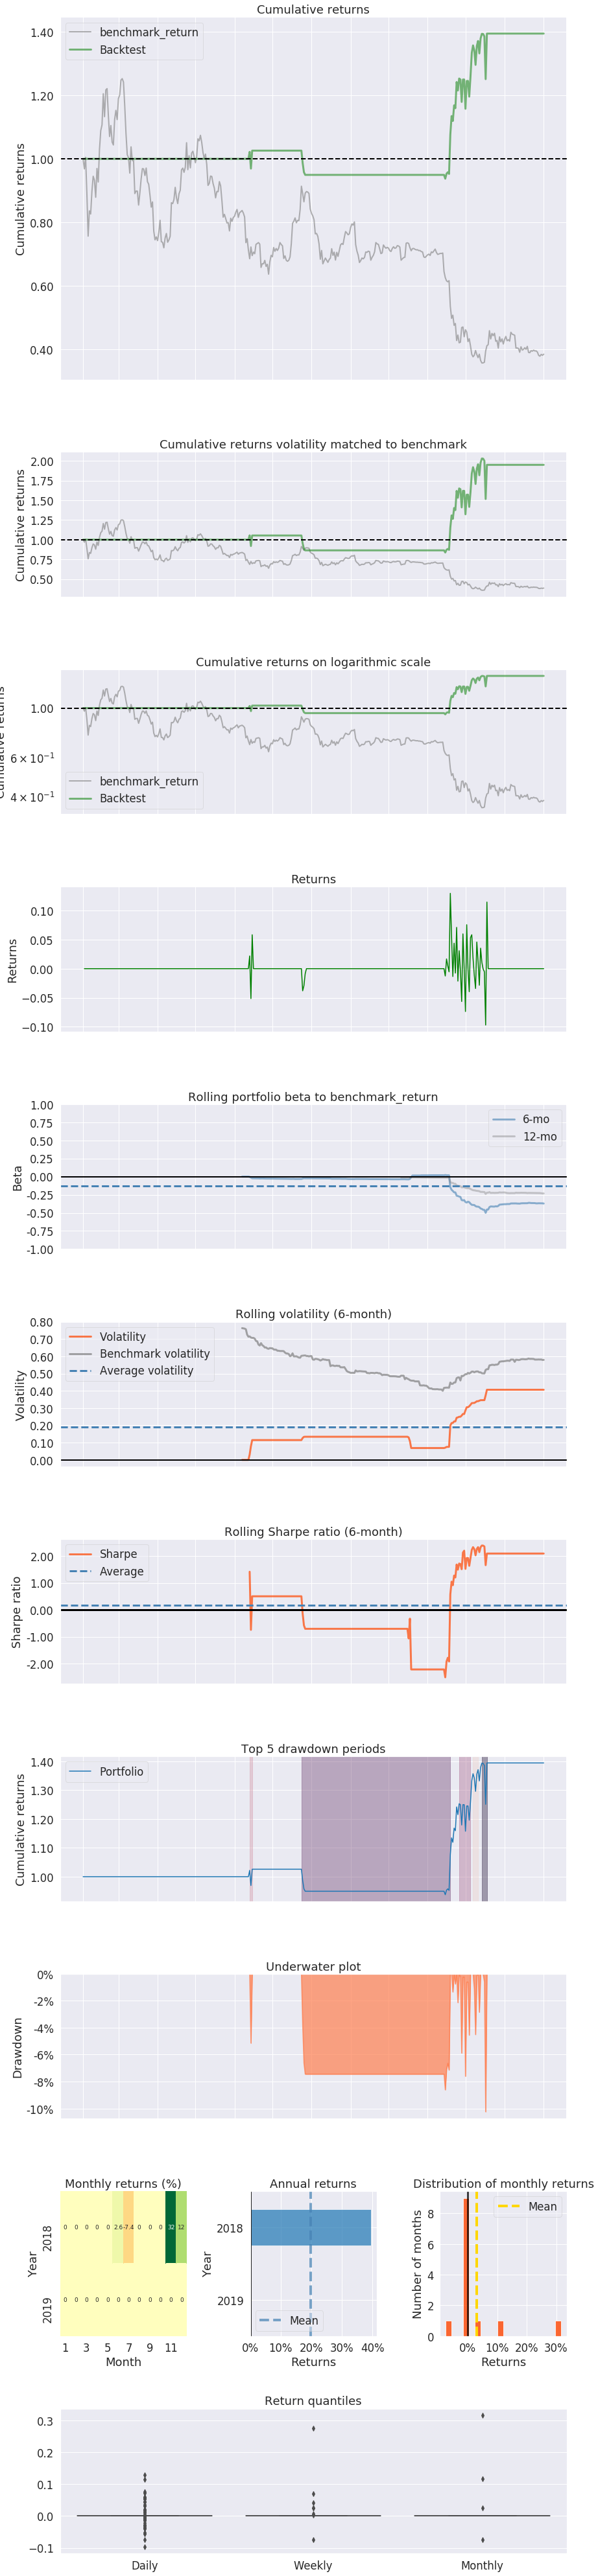

In [72]:
pf.create_returns_tear_sheet(output['strategy_return'], benchmark_rets=output['benchmark_return'])